In [1]:
import pandas as pd 
import numpy as np

import talib

import datetime
import matplotlib.pyplot as plt
from math import sqrt

import tensorflow as tf
from tensorflow import keras

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization

stock="^GSPC"

In [32]:
def Prepare_dataset(df,data_size=300):
    from sklearn.model_selection import train_test_split

    df.dropna(inplace=True,how="all",axis=0)
    #df.fillna(inplace=True,method="ffill")
    df=df.iloc[-data_size:]

    y=df.shift(-1)
    X=df.drop(["Adj Close"],1)
    
    sma15=X["Close"].transform(lambda x: x.rolling(window=15).mean())
    sma5=X["Close"].transform(lambda x: x.rolling(window=5).mean())

    X=X.iloc[15:-1,:]
    y=y.iloc[15:-1,3].values

    X["SMA ratio"]=sma15/sma5
    
    return train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

def Mape(y,y_pred):
    mape=np.mean(np.abs((y.reshape(-1)-y_pred.reshape(-1))/y))*100
    return mape
def Rmse(y,y_pred):
    return np.sqrt(((y_pred.reshape(-1) - y.reshape(-1)) ** 2).mean())

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist["epoch"]=history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error")
    plt.plot(hist.epoch,hist.mae,label="Train error")
    plt.plot(hist.epoch,hist.val_mae,label="Val error")
    plt.legend()
    plt.ylim([0,hist.mae.max()])

def Build_lstm(X_train,X_test,y_train,scale=True):
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph() 

    global lstm_model

    if scale==True:     
        x_scaler = StandardScaler()
        X_train=x_scaler.fit_transform(X_train)
        X_test=x_scaler.transform(X_test)
        
    x_train=np.array(X_train).reshape(X_train.shape[0],X_train.shape[1],1)
    x_test=np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],1)

    lstm_model = Sequential()
    lstm_model.add(LSTM(64,return_sequences=True))
    lstm_model.add(LSTM(128,return_sequences=False))
    lstm_model.add(Dense(units=32))
    lstm_model.add(Dense(units=1))


    lstm_model.compile(loss="mse",optimizer="nadam",metrics=['accuracy'])
    lstm_model.fit(x_train, np.array(y_train), epochs=1000,verbose=0,batch_size=32)
    preds=lstm_model.predict(x_test, batch_size=1)

    return preds



In [2]:
min=pd.read_csv(f"../Data/Prices/{stock}_min.csv")
thirt_min=pd.read_csv(f"../Data/Prices/{stock}_thirt_min.csv")
hour=pd.read_csv(f"../Data/Prices/{stock}_hour.csv")
daily=pd.read_csv(f"../Data/Prices/{stock}_daily.csv")
weekly=pd.read_csv(f"../Data/Prices/{stock}_weekly.csv")

In [34]:
datasets={}
datasets["1m"]=Prepare_dataset(min)
datasets["30m"]=Prepare_dataset(thirt_min)
datasets["1h"]=Prepare_dataset(hour)
datasets["D"]=Prepare_dataset(daily)
datasets["W"]=Prepare_dataset(weekly)

In [39]:
mape=pd.DataFrame(columns=["1m","30m","1h","D","W"])
rmse=pd.DataFrame(columns=["1m","30m","1h","D","W"])

preds={}

for key in datasets:
    X_train=datasets[key][0]
    X_test=datasets[key][1]
    y_train=datasets[key][2]
    y_test=datasets[key][3]

    elastic=ElasticNet().fit(X_train, y_train)
    elastic_preds=elastic.predict(X_test)
    mape.loc["Elastic net",key]=[Mape(y_test,elastic_preds)]
    rmse.loc["Elastic net",key]=[Rmse(y_test,elastic_preds)]

   # lstm_preds=Build_lstm(X_train,X_test,y_train) 
    #mape.loc["LSTM scaled",key]=[Mape(y_test,lstm_preds)]
    #rmse.loc["LSTM scaled",key]=[Rmse(y_test,lstm_preds)]
    #ltsm_models[key]=lstm_model

    preds[key]=[arima_preds,elastic_preds]#,lstm_preds]

    print(f"Model for {key} dataset is done")


Best model:  ARIMA(1,1,0)(0,0,0)[1] intercept
Total fit time: 0.953 seconds
Model for 1m dataset is done

Best model:  ARIMA(0,1,0)(0,0,0)[1] intercept
Total fit time: 0.732 seconds
Model for 30m dataset is done

Best model:  ARIMA(3,1,2)(0,0,0)[1] intercept
Total fit time: 0.934 seconds
Model for 1h dataset is done

Best model:  ARIMA(3,1,2)(0,0,0)[1] intercept
Total fit time: 0.968 seconds
Model for D dataset is done

Best model:  ARIMA(0,1,1)(0,0,0)[1] intercept
Total fit time: 1.084 seconds
Model for W dataset is done


In [40]:
rmse

,1m,30m,1h,D,W
Elastic net,[0.9198931810443114],[6.213486519200544],[10.667467164082037],[43.50781066609829],[130.81155472535588]
ARIMA,[8.021603504519472],[48.335982396103134],[25.45943059619885],[172.32559447771143],[318.4809658628207]


In [41]:
mape

,1m,30m,1h,D,W
Elastic net,[0.018744991557543337],[0.1182183341258105],[0.18759090062103156],[0.9842731749354792],[3.0720356119186754]
ARIMA,[0.17228008942668321],[1.0851818754576734],[0.5583929576580374],[4.160275985419938],[8.24324719329286]


In [6]:
rmse

,1m,30m,1h,D,W
Elastic net,[1.3118654424761003],[8.812095221037964],[9.484366946507516],[47.57157434482108],[123.83885559724676]
Random forest,[1.11460890016265],[9.738332140979955],[14.312427635376949],[106.09888587698117],[219.67243730669293]
ARIMA,[1.1516547773077164],[10.332739494270479],[11.215015153784362],[45.677039668453176],[157.04065967006528]
LSTM scaled,[4.398142972738521],[8.89946412685967],[13.501654543461056],[101.34305975578386],[208.38761268052852]


In [7]:
mape

,1m,30m,1h,D,W
Elastic net,[0.028988272345917457],[0.17831695307727552],[0.1909089576557339],[1.09964996654285],[2.954538096636466]
Random forest,[0.025713763310063777],[0.19440408232972314],[0.31039179955075663],[2.3627361005771],[5.189676347935293]
ARIMA,[0.02266360234237782],[0.20572604403907335],[0.23827069785645255],[1.0030142365131822],[3.6813620106306164]
LSTM scaled,[0.10836537483624176],[0.1767479596932526],[0.3026135541292296],[2.3323282441564768],[5.1415035483319995]


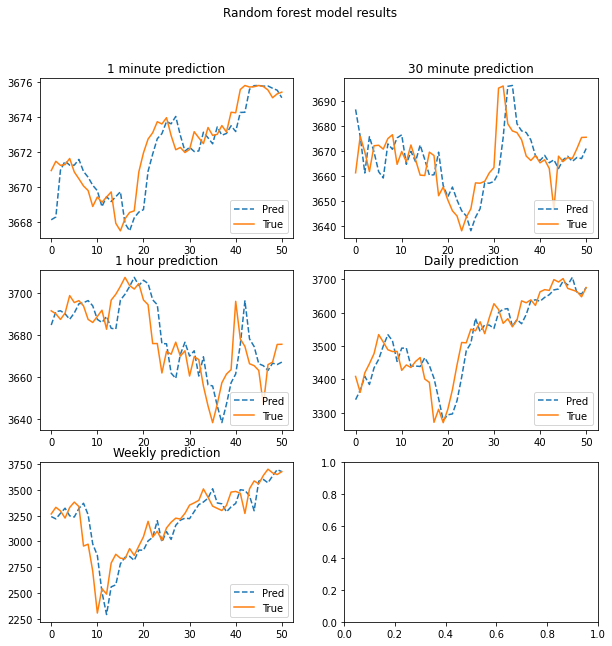

In [10]:
m=0

fig, axs = plt.subplots(3, 2,figsize=(10,10))
fig.suptitle('Random forest model results')

axs[0, 0].set_title('1 minute prediction')
axs[0,0].plot(preds['1m'][m], linestyle='dashed',label="Pred")
axs[0,0].plot(datasets['1m'][3],label="True")
axs[0,0].legend(loc="lower right")

axs[0, 1].set_title('30 minute prediction')
axs[0,1].plot(preds['30m'][m], linestyle='dashed',label="Pred")
axs[0,1].plot(datasets['30m'][3],label="True")
axs[0,1].legend(loc="lower right")

axs[1, 0].set_title('1 hour prediction')
axs[1,0].plot(preds['1h'][m], linestyle='dashed',label="Pred")
axs[1,0].plot(datasets['1h'][3],label="True")
axs[1,0].legend(loc="lower right")

axs[1, 1].set_title('Daily prediction')
axs[1,1].plot(preds['D'][m], linestyle='dashed',label="Pred")
axs[1,1].plot(datasets['D'][3],label="True")
axs[1,1].legend(loc="lower right")

axs[2, 0].set_title('Weekly prediction')
axs[2,0].plot(preds['W'][m], linestyle='dashed',label="Pred")
axs[2,0].plot(datasets['W'][3],label="True")
axs[2,0].legend(loc="lower right")

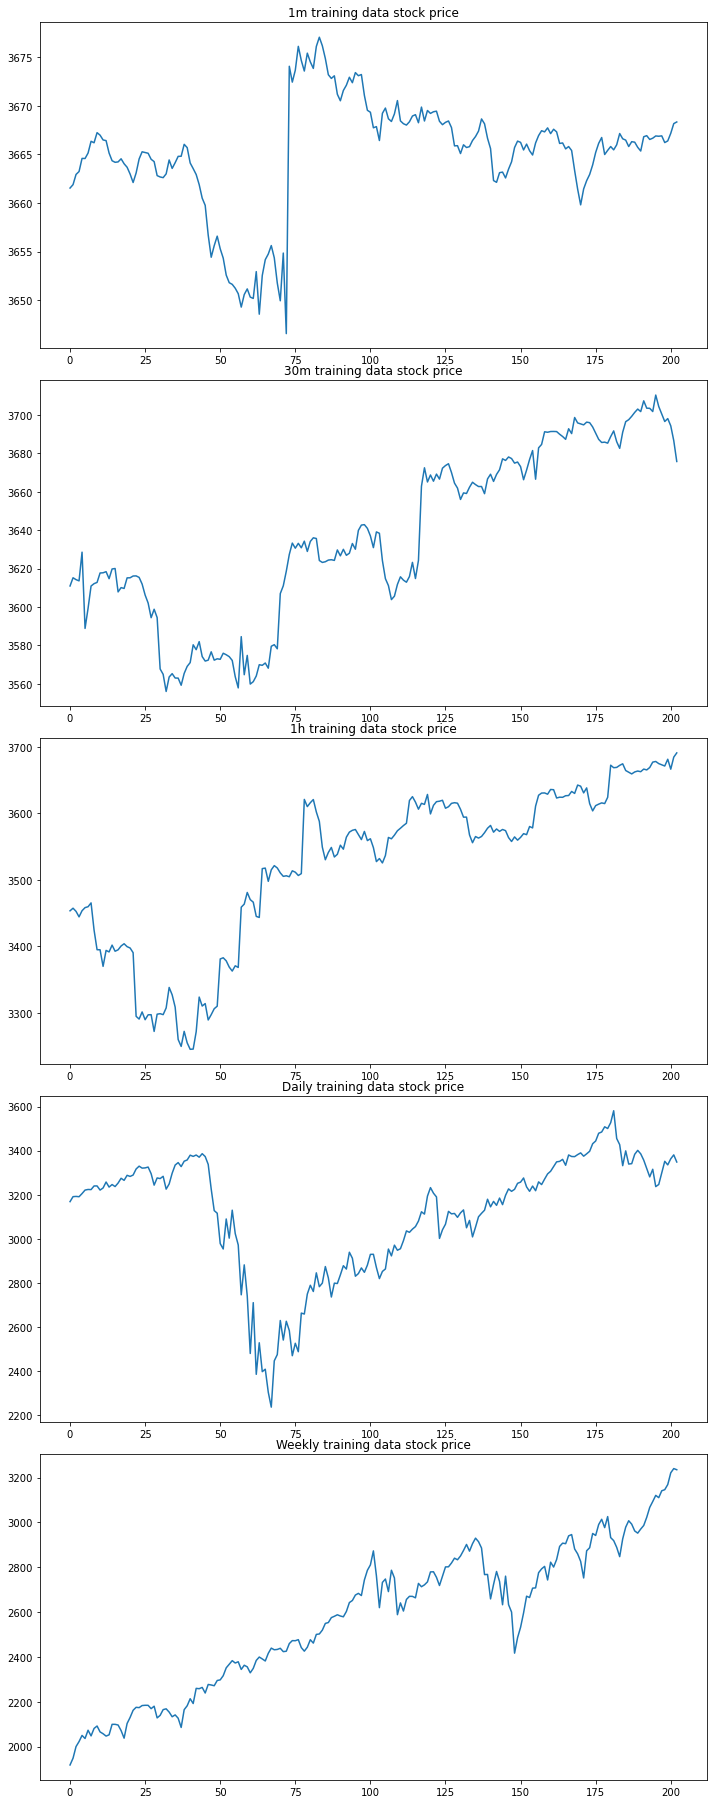

In [11]:

fig, axs = plt.subplots(5, 1,figsize=(10,25))
fig.tight_layout()

axs[0].set_title('1m training data stock price')
axs[0].plot(datasets["1m"][2],label="True")

axs[1].set_title('30m training data stock price')
axs[1].plot(datasets["30m"][2],label="True")

axs[2].set_title('1h training data stock price')
axs[2].plot(datasets["1h"][2],label="True")

axs[3].set_title('Daily training data stock price')
axs[3].plot(datasets["D"][2],label="True")

axs[4].set_title('Weekly training data stock price')
axs[4].plot(datasets["W"][2],label="True")

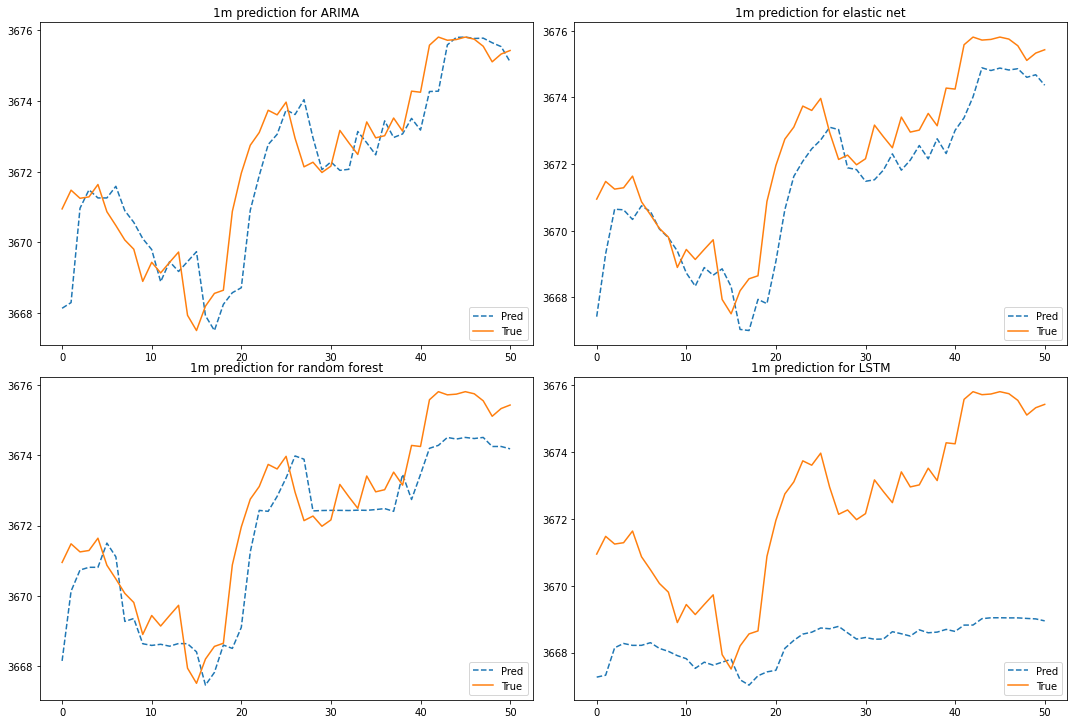

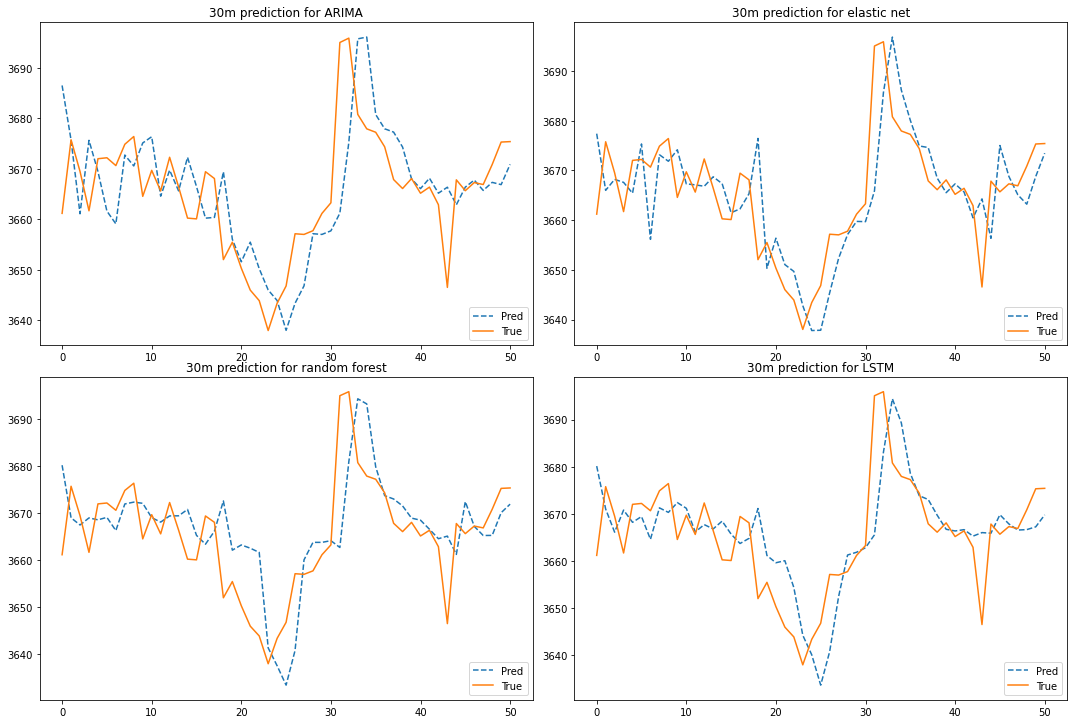

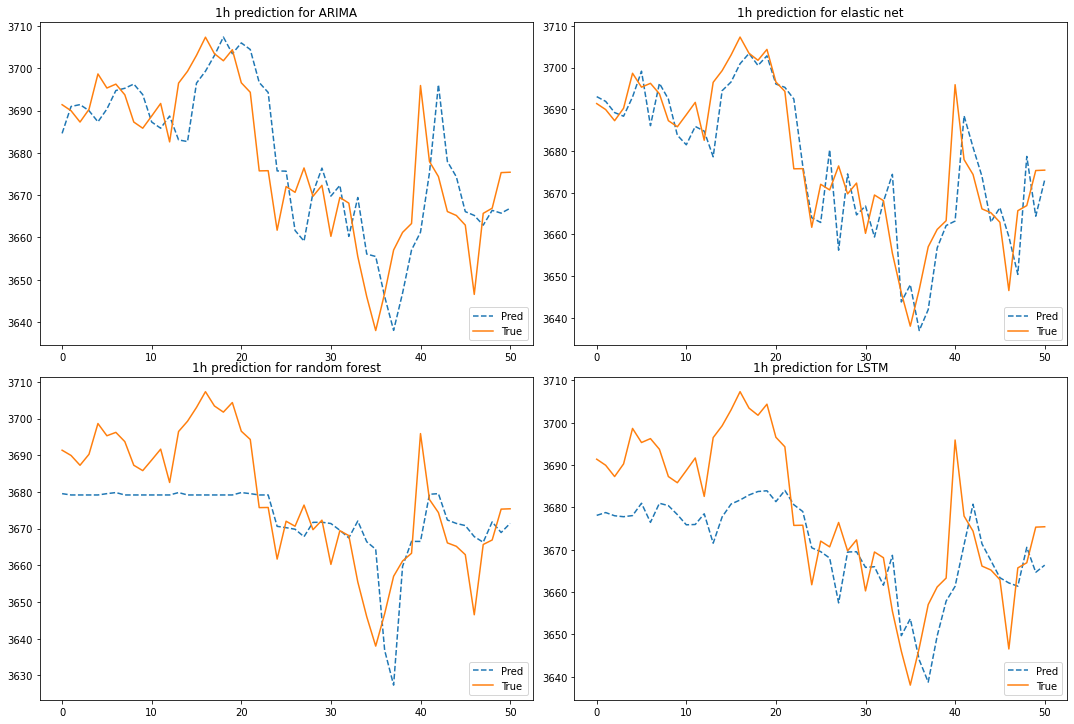

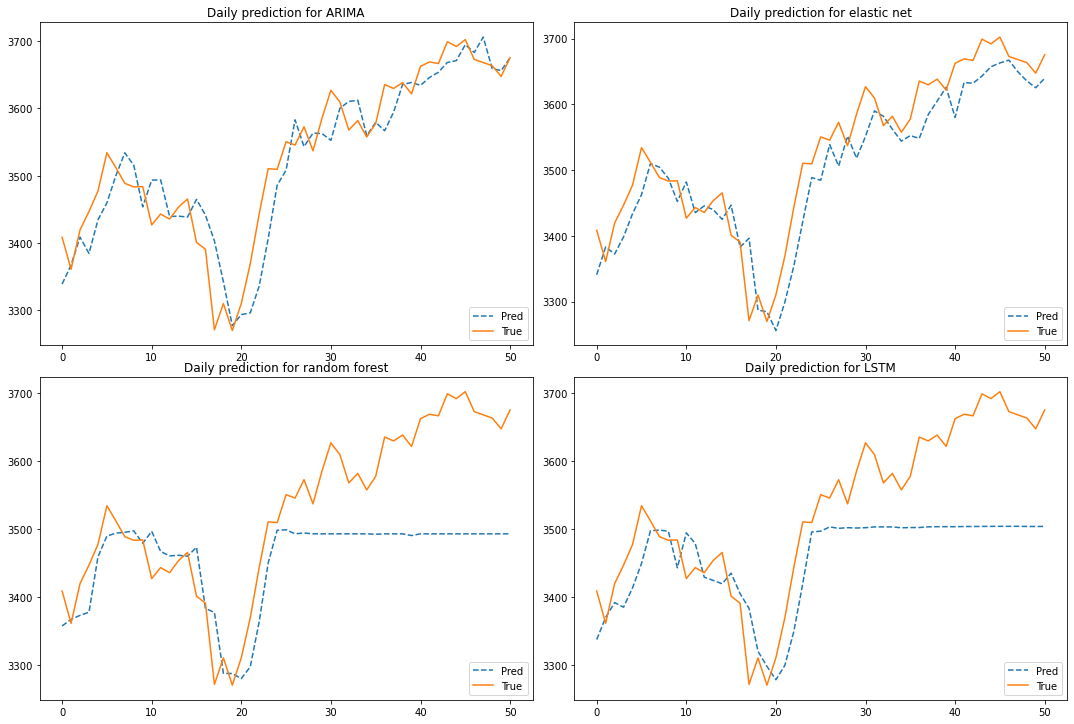

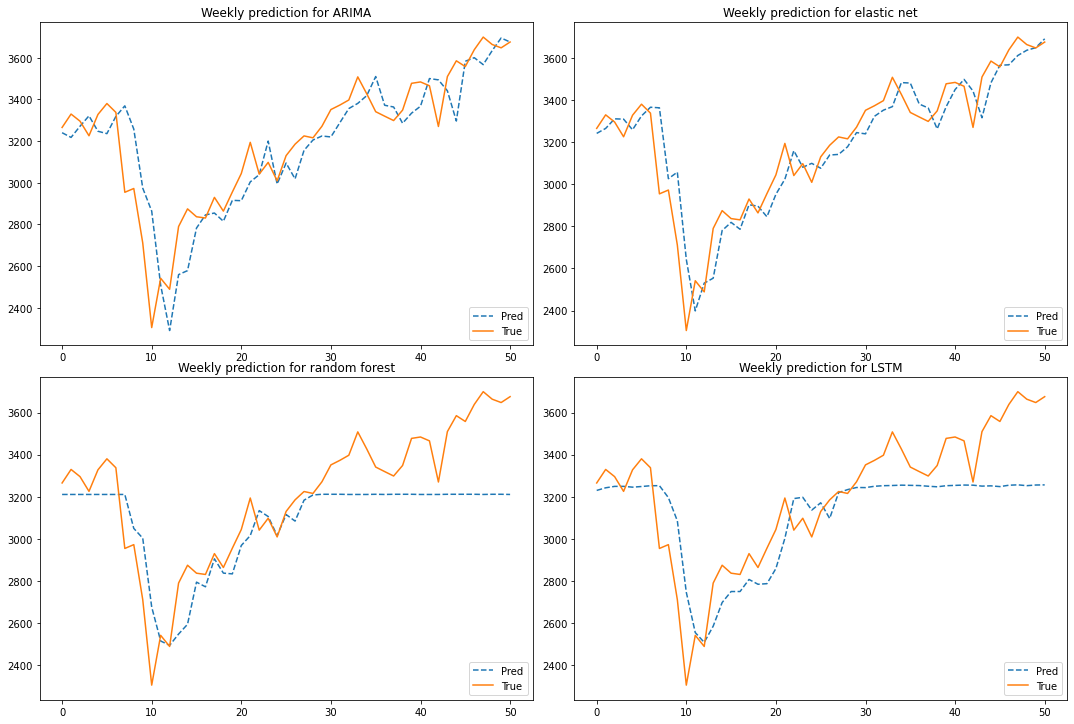

In [12]:
for key in datasets:
    fig, axs = plt.subplots(2, 2,figsize=(15,10))
    fig.tight_layout()

    if key=="D":
        title="Daily"  
    elif key=="W":
        title="Weekly"
    else:
        title=key

    axs[0,0].set_title(f'{title} prediction for ARIMA')
    axs[0,0].plot(preds[key][0], linestyle='dashed',label="Pred")
    axs[0,0].plot(datasets[key][3],label="True")
    axs[0,0].legend(loc="lower right")

    axs[0,1].set_title(f'{title} prediction for elastic net')
    axs[0,1].plot(preds[key][1], linestyle='dashed',label="Pred")
    axs[0,1].plot(datasets[key][3],label="True")
    axs[0,1].legend(loc="lower right")

    axs[1,0].set_title(f'{title} prediction for random forest')
    axs[1,0].plot(preds[key][2], linestyle='dashed',label="Pred")
    axs[1,0].plot(datasets[key][3],label="True")
    axs[1,0].legend(loc="lower right")

    axs[1,1].set_title(f'{title} prediction for LSTM')
    axs[1,1].plot(preds[key][3], linestyle='dashed',label="Pred")
    axs[1,1].plot(datasets[key][3],label="True")
    axs[1,1].legend(loc="lower right")


In [13]:
arima_models["1m"],arima_models["30m"],arima_models["1h"],arima_models["D"],arima_models["W"]

(ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)))